In [1]:
import pandas as pd
import os
import sys
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from psycopg2 import sql

# Navigate to the project root directory and add to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
# Set environment variable for DB password
os.environ['DB_PASSWORD'] = 'fill your_postgres_password_here'  # Update with your actual password

# Establish database connection
try:
    conn = psycopg2.connect(
        host="localhost",
        database="banks_statements",  # Updated database name
        user="postgres",
        password=os.environ.get("DB_PASSWORD")
    )
    print("Successfully connected to PostgreSQL Database.")
    
    # Load data from the database
    query = """
    SELECT 
        r.review_text,
        r.rating,
        r.review_date,
        r.sentiment_label,
        r.identified_themes,
        b.bank_name
    FROM reviews AS r
    JOIN banks AS b ON r.bank_id = b.bank_id;
    """
    df = pd.read_sql_query(query, conn)
    print(f"Successfully loaded {len(df)} records from the database.")

except psycopg2.Error as e:
    print(f"Error connecting to or querying database: {e}")
    df = pd.DataFrame()

finally:
    if conn:
        conn.close()
        print("Database connection closed.")

Successfully connected to PostgreSQL Database.
Successfully loaded 1200 records from the database.
Database connection closed.


C:\Users\hp\AppData\Local\Temp\ipykernel_5776\3314660473.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
if not df.empty:
    # Identify drivers (positive reviews with high ratings)
    drivers_df = df[(df['sentiment_label'] == 'positive') & (df['rating'] >= 4)]
    print("Drivers (Positive Themes):")
    print(drivers_df['identified_themes'].value_counts().head(5))

    # Identify pain points (negative reviews with low ratings)
    pain_points_df = df[(df['sentiment_label'] == 'negative') & (df['rating'] <= 2)]
    print("\nPain Points (Negative Themes):")
    print(pain_points_df['identified_themes'].value_counts().head(5))

    # Compare banks (e.g., CBE vs. BOA)
    cbe_sentiment = df[df['bank_name'] == 'Commercial Bank of Ethiopia']['sentiment_label'].value_counts(normalize=True) * 100
    boa_sentiment = df[df['bank_name'] == 'Bank of Abyssinia']['sentiment_label'].value_counts(normalize=True) * 100

    print("\nSentiment Distribution for Commercial Bank of Ethiopia:")
    print(cbe_sentiment)
    print("\nSentiment Distribution for Bank of Abyssinia:")
    print(boa_sentiment)

Drivers (Positive Themes):
identified_themes
Other                          569
Transaction Performance         52
Customer Support                17
Feature Requests                12
User Interface & Experience      7
Name: count, dtype: int64

Pain Points (Negative Themes):
identified_themes
Other                                        163
Transaction Performance                       32
User Interface & Experience                   11
Feature Requests                              10
Transaction Performance, Feature Requests      8
Name: count, dtype: int64

Sentiment Distribution for Commercial Bank of Ethiopia:
Series([], Name: proportion, dtype: float64)

Sentiment Distribution for Bank of Abyssinia:
Series([], Name: proportion, dtype: float64)


C:\Users\hp\AppData\Local\Temp\ipykernel_5776\1264101886.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='viridis')


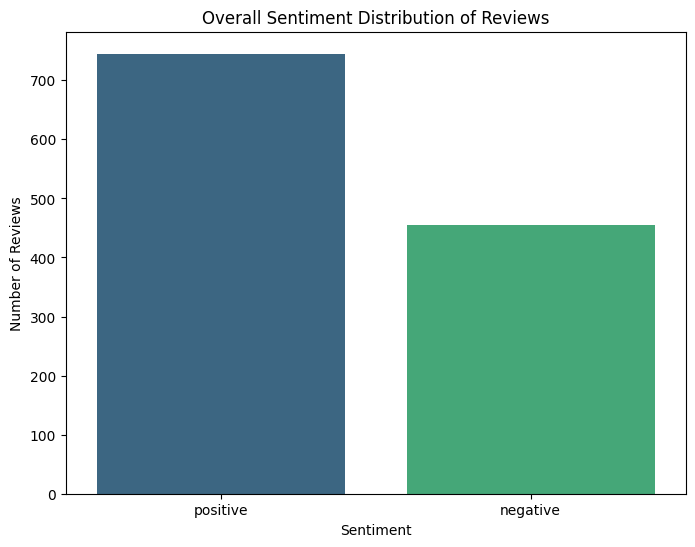

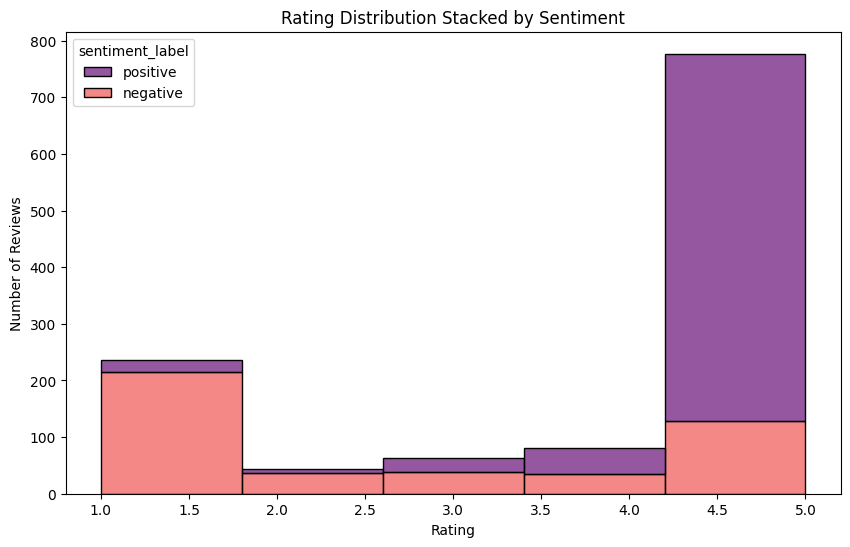

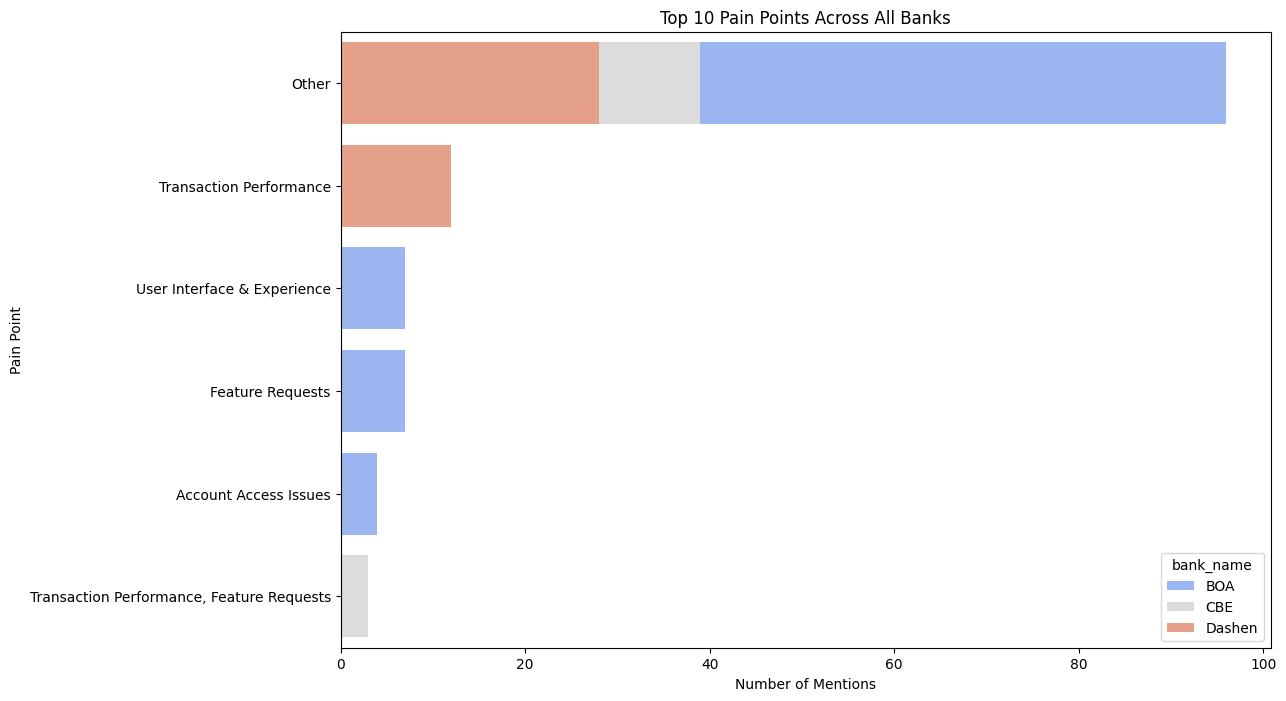

In [6]:
if not df.empty:
    # Plot 1: Overall Sentiment Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='sentiment_label', palette='viridis')
    plt.title('Overall Sentiment Distribution of Reviews')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.show()

    # Plot 2: Rating Distribution by Sentiment
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='rating', hue='sentiment_label', multiple='stack', bins=5, palette='magma')
    plt.title('Rating Distribution Stacked by Sentiment')
    plt.xlabel('Rating')
    plt.ylabel('Number of Reviews')
    plt.show()

    # Plot 3: Top Pain Points by Bank
    # Combine all pain points into a single series for easier plotting
    all_pain_points = pain_points_df.groupby('bank_name')['identified_themes'].value_counts().reset_index(name='count')
    top_pain_points = all_pain_points.sort_values(by='count', ascending=False).head(10)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_pain_points, x='count', y='identified_themes', hue='bank_name', dodge=False, palette='coolwarm')
    plt.title('Top 10 Pain Points Across All Banks')
    plt.xlabel('Number of Mentions')
    plt.ylabel('Pain Point')
    plt.show()